# ITCR - Escuela de Computación, Alajuela
## Curso IC-6200 - Inteligencia Artificial
### Aprendizaje profundo
### Redes Neuronales Convolucionales (CNN)

**Profesora: María Mora**

# Introducción

Las redes convolucionales (LeCun et al., 1989), también conocidas como redes neuronales convolucionales (CNN por sus siglas en inglés) o ConvNet, son un tipo especializado de red neuronal para **procesar datos que tienen una topología similar a una cuadrícula**, por ejemplo los datos de imágenes, que forman una cuadrícula 2D de píxeles. 

Las redes convolucionales han tenido un gran éxito en aplicaciones de visión artificial. El nombre “red neuronal convolucional” indica que **la red emplea una operación matemática llamada convolución**, un tipo especializado de operación lineal. Las redes convolucionales son simplemente redes neuronales que utilizan la convolución en lugar de la multiplicación general de matrices en al menos una de sus capas (Goodfellow, Bengio, and Courville, 2016).

La operación de convolución normalmente se indica con un asterisco de la siguiente forma:

$$ s = (x * w) $$

Con $x$ la entrada, $w$ el kernel y $s$ la salida o mapa de características.

Para imagenes de más dimensiones, por ejemplo, bidimensionales como entrada, se debe usar un kernel K que sea bidimensional.

$$S(i, j) = (I ∗ K)(i, j) = \sum_{i=1}^{m}\sum_{j=1}^{n} I(m, n)K(i − m, j − n)$$

Con $I$ la imagen a procesar, $S$ la salida o mapa de características, ($i$,$j$) la entrada de la matriz de características que se está calculando y $K$ el kernel bidimensional.

Cuando se analiza la convolución en el contexto de las redes neuronales, el proceso que se realiza no es exactamente la operación de convolución discreta estándar tal como se entiende normalmente en matemáticas. En el contexto de las redes neuronales, **la operación consta de muchas aplicaciones de convolución en paralelo**. Esto se debe a que la convolución con un solo kernel puede extraer solo un tipo de característica, aunque en muchas ubicaciones espaciales. Por lo general, se requiere que cada capa de la red extraiga muchos tipos de características, en distintas ubicaciones en los datos de entrada. Una de las técnicas más utilizadas en implementaciones es **cross-correlation**.


## Ejemplo de red convolucional para el procesamiento de imágenes
El objetivo del ejemplo es ensayar la implementación de una CNN utilizando PyTorch y un conjunto de datos estandarizado como el CIFAR10. 

Una animación introductoria de la CNN a implementar está disponible en http://cs231n.stanford.edu/ y una explicación del proceso está disponible en (Stanford, 2022)

## Datos
----------------
PyTorch cuenta con bibliotecas para cargar y preprocesar imágenes. En el caso de visión artificial por ejemplo torchvision, incluye cargadores de datos públicos muy utilizados como Imagenet, CIFAR10, MNIST, entre otras. y paquetes para realizar transformaciones y cargar mini batches como torchvision.datasets y torch.utils.data.DataLoader. Esto ayuda a agilizar el tiempo de preprocesamiento de las entradas algo que se debe repetir fercuentemente. 

En este ejemplo se utilizará el conjuto de datos CIFAR-10. El conjunto de datos CIFAR-10 consta de 60,000 imágenes en color de 32x32 distribuidas en 10 clases, con 6,000 imágenes por clase. Existen 50,000 imágenes de entrenamiento y 10,000 imágenes de prueba. El conjunto de datos fue recolectado por Alex Krizhevsky, Vinod Nair, y Geoffrey Hinton (Krizhevsky et al., n.d.). 

Las clases de las imágenes corresponden a: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. El tamaño de las imágenes es de 3x32x32, i.e. 3-canales de color y 32x32 pixels de tamaño.

![](https://pytorch.org/tutorials/_images/cifar10.png)
Fuente:pytorch.org/tutorials

Las redes neuronales convolucionales aprovechan el hecho de que la entrada consiste en datos que tienen una topología similar a una cuadrícula (ej. imágenes) y restringen la arquitectura para procesar este tipo de entradas. En particular, **a diferencia de una red perceptrón, las capas de una ConvNet tienen neuronas dispuestas en 3 dimensiones: ancho, alto y profundidad**. Por ejemplo, las imágenes de entrada en CIFAR-10 constituyen un volumen de entrada con intensidades de color, y el volumen tiene dimensiones 32x32x3 (ancho, alto, profundidad respectivamente)  (como muestra la siguiente figura). Por lo que las neuronas en una capa solo estarán conectadas a una pequeña región de la capa anterior, en lugar de todas las neuronas de una manera totalmente conectada. Además, la capa de salida final para CIFAR-10 tendría dimensiones 1x1x10, porque al final de la arquitectura ConvNet la salida se reduce a un solo vector de puntajes por clase.

![](https://cs231n.github.io/assets/cnn/cnn.jpeg)

   - La figura muestra una ConvNet que organiza sus neuronas en tres dimensiones (ancho, alto, profundidad), como se visualiza en una de las capas. Cada capa de una ConvNet transforma el volumen de entrada 3D en un volumen de salida 3D de activaciones neuronales. En este ejemplo, la capa de entrada roja contiene la imagen, por lo que su ancho y alto serían las dimensiones de la imagen, y la profundidad sería 3 (canales rojo, verde y azul). Fuente: (Stanford, 2022)

Entrenamiento de una red convolucional para clasificación de imágenes
--------------------------------------------------

Proceso: 

1. Cargar y normalizar los datos utilizando la biblioteca torchvision
2. Definir la red convolucional, entrenar y evaluar el modelo resultante
3. Explorar los datos
4. Probar la red 

In [1]:
# bibliotecas requeridas 

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model evaluation
from sklearn import metrics

## 1. Cargar y normalizar los datos utilizando la biblioteca torchvision

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Definición de los cargadores de datos de entrenamiento y prueba.
# Se definen objetos (tipo DataLoader) para estandarizar la carga de los datos 
# en mini batches.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
 
# Se define el tamaño de los mini batches que se van a utilizar para 
# el entrenamiento y las pruebas.
batch_size = 32

# Se definen los iteradores en los conjuntos de datos de entrenamiento y pruebas
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
 

Files already downloaded and verified
Files already downloaded and verified


## 2. Definir la red convolucional, entrenar y evaluar el modelo resultante


In [3]:
# Definción del modelo

class CIFAR10Model(nn.Module):
    """
    Modelo de red convolucional. Clase que envuelve la clase nn.Module de PyTorch. 
    :params
        torch.nn.Module clase que implenta la funionalidad de
        redes neuronales de Pytorch 
    """

    def __init__(self):

        # Función para definir e inicializar la red.
        super().__init__()
        
        # Capa convolucional
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size...
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        
        # Función de activación de la capa 1
        self.act1 = nn.ReLU()
        
        # Reemplaza por cero aleatoriamente algunos de los pesos 
        # de la red con probabilidad p utilizando muestras 
        # de una distribución de Bernoulli. Esta ha demostrado ser una 
        # técnica eficaz para regularizar y prevenir la coadaptación de las neuronas 
        # como se describe en (Hinton et al., 2012).
        self.drop1 = nn.Dropout(0.)
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        
        #torch.nn.MaxPool2d(kernel_size, stride,...        
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(512, 10)
 
    def forward(self, x):
        # Aplica el modelo a los datos de entrada.
        # :param
        #   x : datos de la imagen a procesar.
        
        #Pase de la entrada por todas las capas de la red.
        
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x
 


In [4]:
# Entrenamiento de la red
def model_training(n_epochs, model, loss_fn, optimizer, trainloader, testloader):
    train_losses = []
    test_losses = []

    model.train()
    for epoch in range(n_epochs):
        ######################
        # Entrenar el modelo #
        ######################
        epoch_train_loss = 0
        for inputs, labels in trainloader:
            # forward, backward, y actualización de pesos
            optimizer.zero_grad()

            y_pred = model(inputs)
            loss = loss_fn(y_pred, labels)
            # Para calcular y luego desplegar la pérdida
            epoch_train_loss += loss.item()*inputs.size(0)
            
            loss.backward()
            optimizer.step()

        # to display the error curve
        #train_loss = loss.item()
        train_losses.append(epoch_train_loss/len(trainloader.dataset))
    
            
        ######################    
        # Evaluación del modelo #
        ######################
        acc = 0
        count = 0
        model.eval()
        with torch.no_grad():
            # Model in eval mode
            epoch_test_loss = 0

            for inputs, labels in testloader:
                y_pred = model(inputs)
                
                test_loss = loss_fn(y_pred, labels)
                
                #print("Test ", test_loss)
                # Para calcular y luego deplegar la pérdida
                epoch_test_loss += test_loss.item()*inputs.size(0)
               
                # Totales
                acc += (torch.argmax(y_pred, 1) == labels).float().sum()
                count += len(labels)
            acc /= count                
            test_losses.append(epoch_test_loss/len(testloader.dataset))

        print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

        
    return model, train_losses, test_losses

# Definción del modelo
n_epochs = 5
model = CIFAR10Model()

# Funciones de optimización y pérdida
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#Entrenamiento del modelo
model, train_losses, test_losses =  model_training(n_epochs, model, loss_fn, optimizer, 
                              trainloader, testloader)   
 


Epoch 0: model accuracy 37.90%
Epoch 1: model accuracy 46.62%
Epoch 2: model accuracy 48.68%
Epoch 3: model accuracy 54.43%
Epoch 4: model accuracy 54.73%


## 3. Explorar los datos

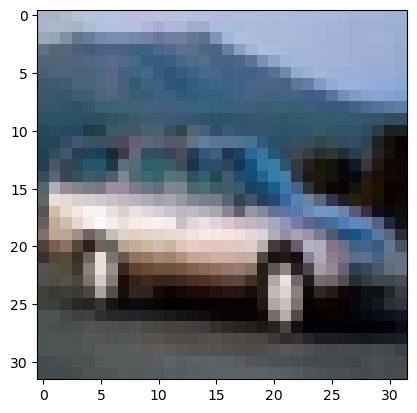

In [5]:
plt.imshow(trainset.data[4])
plt.show()

In [6]:
# Funciones para desplegar algunas imágenes de forma aleatoria. 

def imshow(img):
    img = img / 2 + 0.5     # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


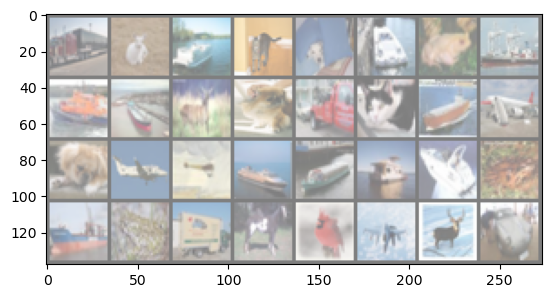

Etiqueta verdadera:  truck  deer  ship   cat   dog  ship  frog  ship  ship  ship  deer   dog truck   cat  ship plane   dog plane plane  ship  ship  ship  ship  frog  ship  frog truck horse  bird plane  deer   car


In [7]:
#Calses asociadas a las imágenes.
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(testloader)
images, labels = next(dataiter)

# imprimir algunos ejemplos y la etiqueta original (la verdad)
imshow(torchvision.utils.make_grid(images))
print('Etiqueta verdadera: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## 4. Exploración de la red 

In [8]:
outputs = model(images)
print(outputs)

tensor([[ 1.5726e+00,  1.1383e+00, -9.8479e-01, -1.5915e+00, -2.0012e+00,
         -2.1609e+00, -2.6815e+00,  4.0629e-01,  5.0405e-01,  4.4967e+00],
        [ 1.4860e-01, -2.6132e+00,  1.2827e+00,  2.4548e+00,  6.6072e-01,
          3.0663e+00,  1.1226e+00, -6.9238e-02, -1.6808e+00, -2.8758e+00],
        [ 3.2538e+00,  3.2907e+00, -5.0126e-01, -2.7469e+00, -2.9329e+00,
         -1.3945e+00, -7.0780e+00, -4.0914e-01,  3.6290e+00,  2.6239e+00],
        [ 1.5755e-01, -2.2592e+00,  9.3105e-01,  1.4094e+00,  1.3972e+00,
          2.4356e+00,  1.3737e+00, -4.5376e-01, -2.5533e+00, -2.3869e+00],
        [ 1.0645e+00, -3.1529e-01,  5.5854e-01,  7.4298e-02,  8.7585e-01,
         -2.4983e-01, -1.8431e+00, -1.0314e+00,  1.3462e+00, -9.7450e-01],
        [-1.3354e+00,  1.2750e+00, -1.6135e+00,  1.3234e+00, -3.9234e+00,
          2.4787e+00, -3.3210e+00, -8.1226e-01,  2.2386e+00,  3.0790e+00],
        [-1.4439e+00,  7.9592e-02, -1.0993e+00,  2.3060e+00, -1.7733e-01,
          2.1116e+00,  2.1701e+0

La capa de salida contiene 10 neuronas que representan las 10 clases involucradas en la clasificación. El resultado mayor indica que la imagen pertenece a la clase particular.

In [9]:
_, predicted = torch.max(outputs, 1)

print('Predicción: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))
print(predicted)

Predicción:  truck   dog  ship   dog  ship truck   cat  ship truck  ship horse   cat truck   dog  ship plane  frog plane plane  ship   car  ship   dog  deer  ship   dog truck horse truck plane plane truck
tensor([9, 5, 8, 5, 8, 9, 3, 8, 9, 8, 7, 3, 9, 5, 8, 0, 6, 0, 0, 8, 1, 8, 5, 4,
        8, 5, 9, 7, 9, 0, 0, 9])


## 5. Evaluación del modelo y curva de error

In [10]:
# Se toma todos los datos de prueba y se verifica si el modelo realiza
# bien la predicción para cada una de las 10 clases individuales. 

# Cantidad de imágenes correctamente clasificadas por clase
class_correct = list(0. for i in range(10))

# Cantidad de imágenes por clase.
class_total = list(0. for i in range(10))

#Para todas las imágenes de prueba se realiza el forward
# y se evalúa si el resultado fue el correcto y la clase 
# a la que pertenece la imagen.
with torch.no_grad():
    for data in testloader:
        #Se dividen las imágenes de las etiquetas.
        images, labels = data
        
        #Se clasificacan las imágenes usando el modelo.
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        #Se compara el resultado de la predicción con el 
        # valor esperado y se cuentan los casos exitosos por clase.
        c = (predicted == labels).squeeze()
        
        for i in range(labels.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Se imprime el resultado
for i in range(10):
    print('Exactitud en %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Exactitud en plane : 58 %
Exactitud en   car : 73 %
Exactitud en  bird : 29 %
Exactitud en   cat : 20 %
Exactitud en  deer : 39 %
Exactitud en   dog : 71 %
Exactitud en  frog : 61 %
Exactitud en horse : 53 %
Exactitud en  ship : 76 %
Exactitud en truck : 65 %


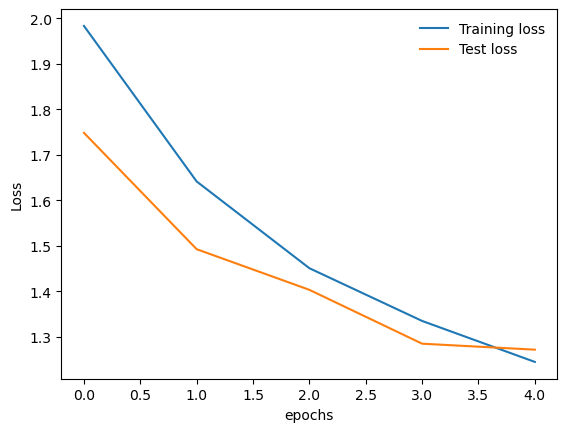

In [11]:
## Loss curve

def loss_curve (train_losses,test_losses, y_label):
    """ 
    Displays the loss curve.
    Parameters: 
       train_losses: list of loss values per epoch using training data.
       test_losses: list of loss values per epoch using test data.
       test_accuracies: : a list of accuracie by epoch using test data. 
       y_label
    """  
    plt.figure()
    plt.xlabel('epochs')
    plt.ylabel(y_label)
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Test loss')
    plt.legend(frameon=False);

loss_curve (train_losses,test_losses, 'Loss')

Accuracy: 0.55
Details:
              precision    recall  f1-score   support

         0.0       0.61      0.58      0.59      1000
         1.0       0.59      0.73      0.66      1000
         2.0       0.57      0.29      0.39      1000
         3.0       0.44      0.20      0.27      1000
         4.0       0.58      0.39      0.47      1000
         5.0       0.38      0.71      0.49      1000
         6.0       0.64      0.61      0.62      1000
         7.0       0.67      0.53      0.59      1000
         8.0       0.57      0.77      0.65      1000
         9.0       0.56      0.65      0.60      1000

    accuracy                           0.55     10000
   macro avg       0.56      0.55      0.53     10000
weighted avg       0.56      0.55      0.53     10000



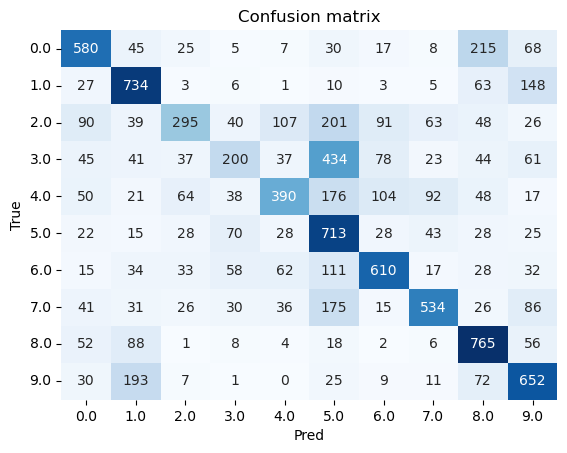

In [12]:
# Evaluate model performance

def model_predition(model):
    predicted = torch.Tensor([])
    y_test = torch.Tensor([])

    for inputs, labels in testloader:
        y_pred = model(inputs)
        
        # Extract predictions
        _, pred = torch.max(y_pred, 1)    
        
        # Concat predicted and labels
        predicted = torch.cat((predicted,pred))
        y_test = torch.cat((y_test, labels))
    return y_test, predicted

def plot_confusion_matrix(y_test, predicted):    
    """
    Displays the confusion matrix and other metrics.
    
    Parameters:
      y_test : a list of test data. 
      predicted: a list of model results
    """
    classes = np.unique(y_test)
    
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, predicted)

    print("Accuracy:",  round(accuracy,2))
    print("Details:")
    print(metrics.classification_report(y_test, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    plt.show()

y_test, predicted = model_predition(model)    
plot_confusion_matrix(y_test, predicted)

In [13]:
torch.save(model.state_dict(), "cifar10model.pth")

## Referencias y material de interés

[1] Tam, Adrian (2023). Building a Convolutional Neural Network in PyTorch. Recuperado de https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/

[2] Krizhevsky, A., Nair, G, & Hinton, G. The CIFAR-10 dataset (n.d.).  Recuperado de https://www.cs.toronto.edu/~kriz/cifar.html

[3] Recommended approach for saving a model. <https://pytorch.org/docs/stable/notes/serialization.html>

[4] Krajewski, J. (2020). PyTorch layer dimensions: what size and why?. Recuperado de https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd

[5] Stanford (2022). Convolutional Neural Networks (CNNs / ConvNets) for Visual Recognition. Recuperado de 
https://cs231n.github.io/convolutional-networks/. 

[6] LeCun, Y., Jackel, L. D., Boser, B., Denker, J. S., Graf, H. P., Guyon, I., Henderson, D., Howard, R. E., and Hubbard, W. (1989). Handwritten digit recognition: Applications of neural network chips and automatic learning. IEEE Communications Magazine, 
 27(11), 41–46.

[7] Goodfellow, I., Bengio, Y., Courville, A. (2016). Deep Learning. MIT Press. Recuperado de https://www.deeplearningbook.org/

[8] PyTorch. CONV2D. https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

[9] Geoffrey E. Hinton, Nitish Srivastava, Alex Krizhevsky, Ilya Sutskever, Ruslan R. Salakhutdinov (2012). Improving neural networks by preventing co-adaptation of feature detectors. Recuperado de https://arxiv.org/abs/1207.0580

[10] Brownlee, J. (2019). How to use Learning Curves to Diagnose Machine Learning Model Performance. Recuperado de https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

[11] Soleymani, A. (2022). Your validation loss is lower than your training loss? This is why!. Recuperado de https://towardsdatascience.com/what-your-validation-loss-is-lower-than-your-training-loss-this-is-why-5e92e0b1747e

[12] Gangoly, S. (2021). CNN on CIFAR10 Data set using PyTorch. Recuperado de https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844

[13] HuggingFace (2023). Image classification. https://huggingface.co/docs/transformers/tasks/image_classification 
